## Ridge and Logistic Regression (Fall 2022)


## Set up
This notebook is tested under [python 3. * . *](https://www.python.org/downloads/release/python-368/), and the corresponding packages can be downloaded from [miniconda](https://docs.conda.io/en/latest/miniconda.html). You may also want to get yourself familiar with several packages:

- [jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/)
- [numpy](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [matplotlib](https://matplotlib.org/users/pyplot_tutorial.html)
- [sklearn](https://matplotlib.org/users/pyplot_tutorial.html)
- [Axes3D](https://matplotlib.org/users/pyplot_tutorial.html)


## Library imports

In [35]:
# This is cell which sets up some of the modules you might need 
# Please do not change the cell or import any additional packages. 

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
import warnings
import sys
from tqdm.notebook import tqdm

print('Version information')

print('python: {}'.format(sys.version))
print('matplotlib: {}'.format(matplotlib.__version__))
print('numpy: {}'.format(np.__version__))

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Version information
python: 3.10.6 | packaged by conda-forge | (main, Oct 24 2022, 16:02:16) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.5.2
numpy: 1.23.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Polynomial regression and regularization

### General Functions and Linear Regression
In this section. we will test the performance of the linear regression. Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5.
Each data sample consists of two features $[a,b]$. We compute the polynomial features of both $a$ and $b$ in order to yield the vectors $[1,a,a^2,a^3, \ldots, a^{degree}]$ and $[1,b,b^2,b^3, \ldots, b^{degree}]$. We train our model with the cartesian product of these polynomial features. The cartesian product generates a new feature vector consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.

For example, if degree = 2, we will have the polynomial features $[1,a,a^2]$ and $[1,b,b^2]$ for the datapoint $[a,b]$. The cartesian product of these two vectors will be $[1,a,b,ab,a^2,b^2]$. We do not generate $a^3$ and $b^3$ since their degree is greater than 2 (specified degree).



In [36]:
from regression import Regression

In [37]:
POLY_DEGREE = 7
N_SAMPLES = 1200

rng = np.random.RandomState(seed=10)

# Simulating a regression dataset with polynomial features.
true_weight = rng.rand(POLY_DEGREE ** 2 + 2, 1)
x_feature1 = np.linspace(-5, 5, N_SAMPLES)
x_feature2 = np.linspace(-3, 3, N_SAMPLES)
x_all = np.stack((x_feature1, x_feature2), axis=1)

reg = Regression()
x_all_feat = reg.construct_polynomial_feats(x_all, POLY_DEGREE)
x_cart_flat = []
for i in range(x_all_feat.shape[0]):
    point = x_all_feat[i]
    x1 = point[:,0]
    x2 = point[:,1]
    x1_end = x1[-1]
    x2_end = x2[-1]
    x1 = x1[:-1]
    x2 = x2[:-1]
    x3 = np.asarray([[m*n for m in x1] for n in x2])

    x3_flat = list(np.reshape(x3, (x3.shape[0] ** 2)))
    x3_flat.append(x1_end)
    x3_flat.append(x2_end)
    x3_flat = np.asarray(x3_flat)
    x_cart_flat.append(x3_flat)
  
x_cart_flat = np.asarray(x_cart_flat)
x_cart_flat = (x_cart_flat - np.mean(x_cart_flat)) / np.std(x_cart_flat)  # Normalize
x_all_feat = np.copy(x_cart_flat)

# We must add noise to data, else the data will look unrealistically perfect.
y_noise = rng.randn(x_all_feat.shape[0], 1)
y_all = np.dot(x_cart_flat, true_weight) + y_noise
print("x_all: ", x_all.shape[0], " (rows/samples) ", x_all.shape[1], " (columns/features)", sep="")
print("y_all: ", y_all.shape[0], " (rows/samples) ", y_all.shape[1], " (columns/features)", sep="")

x_all: 1200 (rows/samples) 2 (columns/features)
y_all: 1200 (rows/samples) 1 (columns/features)


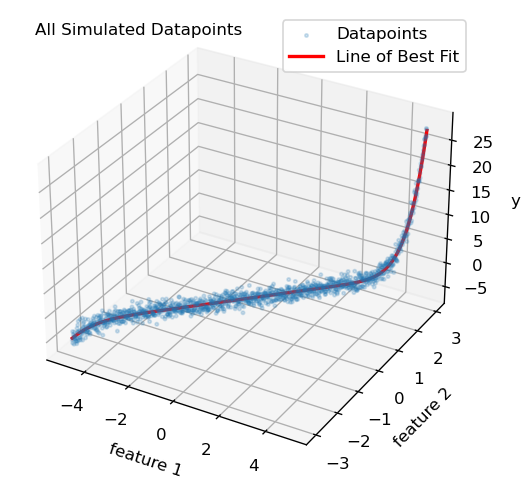

In [38]:
fig = plt.figure(figsize=(8,5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

p = np.reshape(np.dot(x_cart_flat, true_weight), (N_SAMPLES,))
ax.scatter(x_all[:,0], x_all[:,1], y_all, label='Datapoints', s=4, alpha=0.2)
ax.plot(x_all[:,0], x_all[:,1], p, label='Line of Best Fit', c="red", linewidth=2)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("y")

ax.legend()
ax.text2D(0.05, 0.95, "All Simulated Datapoints", transform=ax.transAxes)
plt.show()

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy data points. The data points are generated by  $Y=X\theta+\epsilon$, where $\epsilon_i \sim N(0,1)$  are i.i.d. generated noise.

Now let's split the data into two parts, the training set and testing set. The yellow dots are for training, while the black dots are for testing.

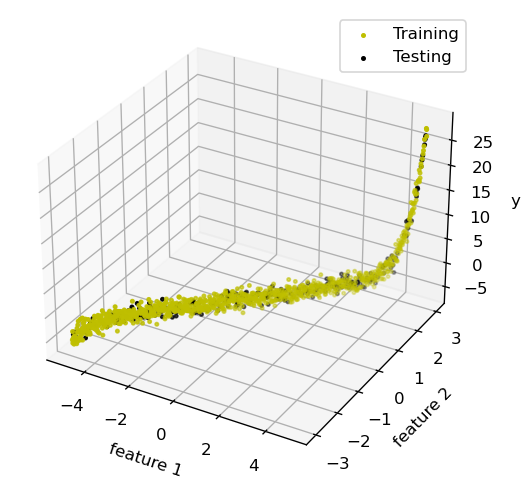

In [39]:
PERCENT_TRAIN = 0.8

all_indices = rng.permutation(N_SAMPLES)  # Random indicies
train_indices = all_indices[:round(N_SAMPLES * PERCENT_TRAIN)]  # 80% Training
test_indices = all_indices[round(N_SAMPLES * PERCENT_TRAIN):]  # 20% Testing

xtrain = x_all[train_indices]
ytrain = y_all[train_indices]
xtest = x_all[test_indices]
ytest = y_all[test_indices]

# -- Plotting Code --
fig = plt.figure(figsize=(8,5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xtrain[:,0], xtrain[:,1], ytrain, label='Training', c='y',s=4)
ax.scatter(xtest[:,0], xtest[:,1], ytest, label='Testing', c='black',s=4)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("y")
    
ax.legend(loc = 'upper right')
plt.show()

Now let us train our model using the training set and see how our model performs on the testing set. Observe the red line, which is our model's learned function.

Linear (closed) RMSE: 0.9097


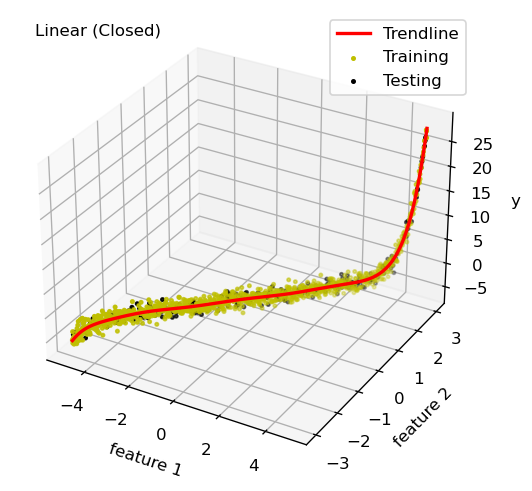

In [40]:
weight = reg.linear_fit_closed(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('Linear (closed) RMSE: %.4f' % test_rmse)

# -- Plotting Code --
fig = plt.figure(figsize=(8,5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

y_pred = reg.predict(x_all_feat, weight)
y_pred = np.reshape(y_pred, (y_pred.size,))
ax.plot(x_all[:,0], x_all[:,1], y_pred, label='Trendline', color='r', lw=2, zorder=5)

ax.scatter(xtrain[:,0], xtrain[:,1], ytrain, label='Training', c='y',s=4)
ax.scatter(xtest[:,0], xtest[:,1], ytest, label='Testing', c='black',s=4)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("y")

ax.text2D(0.05, 0.95, "Linear (Closed)", transform=ax.transAxes)
ax.legend(loc = 'upper right')
plt.show()

We must tune our epochs and learning_rate. As we tune these parameters our trendline will approach the trendline generated by the linear closed form solution. Observe how we slowly tune (increase) the epochs and learning_rate below to create a better model.

Note that the closed form solution will always give the most optimal/overfit results. We cannot outperform the closed form solution with GD. We can only approach closed forms level of optimality/overfitness.

And what if we just use the first 10 data points to train?

In [41]:
rng = np.random.RandomState(seed=5)
y_all_noisy = np.dot(x_cart_flat, np.zeros((POLY_DEGREE ** 2 + 2, 1))) + rng.randn(x_all_feat.shape[0], 1)
sub_train = train_indices[10:20]

Linear (closed) 10 Samples RMSE: 2457.9318


Text(0.05, 0.95, 'Linear Regression (Closed)')

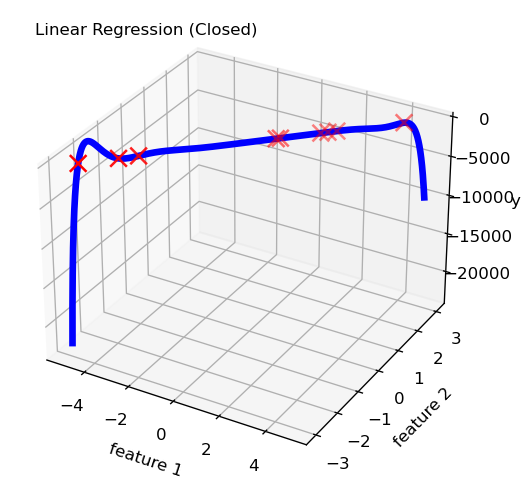

In [42]:
weight = reg.linear_fit_closed(x_all_feat[sub_train], y_all_noisy[sub_train])
y_pred = reg.predict(x_all_feat, weight)
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all_noisy[test_indices])
print('Linear (closed) 10 Samples RMSE: %.4f' % test_rmse)

# -- Plotting Code --
fig = plt.figure(figsize=(8,5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

x1 = x_all[:,0]
x2 = x_all[:,1]
y_pred = np.reshape(y_pred, (N_SAMPLES,))
ax.plot(x1, x2, y_pred, color='b', lw=4)

x3 = x_all[sub_train,0]
x4 = x_all[sub_train,1]
ax.scatter(x3, x4, y_all_noisy[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices], weight)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("y")
ax.set_zlim([None, 8])

ax.text2D(0.05, 0.95, "Linear Regression (Closed)", transform=ax.transAxes)

### Testing ridge regression

Ridge Regression (closed) RMSE: 1.4765


Text(0.05, 0.95, 'Ridge Regression (Closed)')

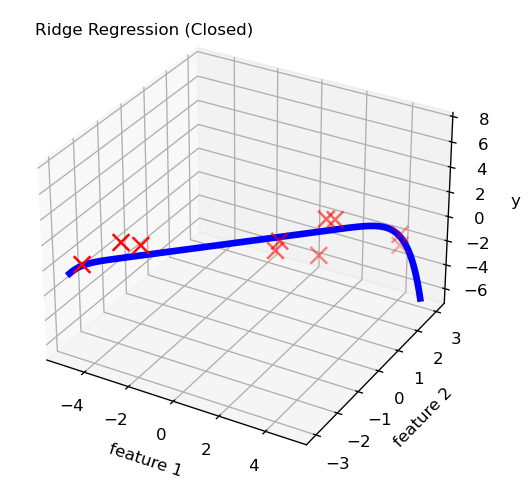

In [43]:
weight = reg.ridge_fit_closed(x_all_feat[sub_train],
                              y_all_noisy[sub_train],
                              c_lambda=10)
y_pred = reg.predict(x_all_feat, weight)
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all_noisy[test_indices])
print('Ridge Regression (closed) RMSE: %.4f' % test_rmse)

# -- Plotting Code --
fig = plt.figure(figsize=(8,5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

x1 = x_all[:,0]
x2 = x_all[:,1]
y_pred = np.reshape(y_pred, (N_SAMPLES,))
ax.plot(x1, x2, y_pred, color='b', lw=4)

x3 = x_all[sub_train,0]
x4 = x_all[sub_train,1]
ax.scatter(x3, x4, y_all_noisy[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices], weight)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("y")

ax.set_zlim([None, 8])
ax.text2D(0.05, 0.95, "Ridge Regression (Closed)", transform=ax.transAxes)

### Cross validation
Let's use Cross Validation to search for the best value for `c_lambda` in ridge regression.

We provided a list of possible values for lambda which we will use in cross validation.
For cross validation, we will use 10-fold method and only use it for training data.
For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training
At the end for each lambda, we will have calculated 10 rmse values, and get the mean value of that.
Then we will use the lambda with the lowest mean value of rmse. 

In [44]:
lambda_list = [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100, 1000, 10000]
kfold = 10

best_lambda, best_error, error_list = reg.hyperparameter_search(x_all_feat[train_indices], y_all[train_indices], lambda_list, kfold)
for lm, err in zip(lambda_list, error_list):
    print('Lambda: %.4f' % lm, 'RMSE: %.6f'% err)

print('Best Lambda: %.4f' % best_lambda)
weight = reg.ridge_fit_closed(x_all_feat[train_indices], y_all_noisy[train_indices], c_lambda=best_lambda)
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all_noisy[test_indices])
print('Best Test RMSE: %.4f' % test_rmse) 

Lambda: 0.0001 RMSE: 1.013414
Lambda: 0.0010 RMSE: 1.013076
Lambda: 0.1000 RMSE: 1.012465
Lambda: 1.0000 RMSE: 1.011756
Lambda: 5.0000 RMSE: 1.011457
Lambda: 10.0000 RMSE: 1.011729
Lambda: 50.0000 RMSE: 1.012989
Lambda: 100.0000 RMSE: 1.014559
Lambda: 1000.0000 RMSE: 1.137698
Lambda: 10000.0000 RMSE: 2.455097
Best Lambda: 5.0000
Best Test RMSE: 0.9444


### News Data Sentiment Classification via Logistic Regression

 This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. The sentiment of news has 3 classes, negative, positive and neutral. In this problem, we only use the negative(class label = 0) and positive(class label = 1) classes for binary logistic regression. For data preprocessing, we remove the duplicate headlines and remove the neutral class to get 1967 unique news headlines. Then we randomly split the 1967 headlines into training set and evaluation set with 8:2 ratio. We use the training set to fit a binary logistic regression model.

The code which is provided loads the documents, preprocess the data, builds a [“bag of words” representation](https://en.wikipedia.org/wiki/Bag-of-words_model)  of each document. Then using the functions in <strong>logisticRegression.py</strong>, we will determine whether a news headline is negative or positive.

##### Logistic Regression Overview:
1. In logistic regression, we model the conditional probability using parameters $\theta$, which includes a bias term b. 
$$p(y_i=1\, |\, x_i;\theta )\, =\, {h}_{\theta }(x_i) = {\sigma}(x\theta)$$
$$p(y_i=0\, |\, x_i;\theta )\, =\, {1-h}_{\theta }(x_i) $$

where $\sigma(\cdot)$ is the sigmoid function as follows:
$$\sigma(s) = \frac{1}{1+e^{-s}}$$

2. The conditional probabilities of the positive class $(y=1)$ and the negative class $(y=0)$ of the sample $x_i$ attributes are combined into one equation as follows:

$$ p(y_i\, |\, x_i;\theta )\, =\, {({h}_{\theta }(x_i))}^{y_i}\, {(1-{h}_{\theta }(x_i))}^{1-y_i} $$

3. Assuming that the samples are independent of each other, the likelihood of the entire dataset is the product of the probabilities of all samples. We use maximum likehood estimation to estimate the model parameters $\theta$. The negative log likelihood (scaled by the dataset size $N$) is given by:
$$ \mathcal{L}(\theta )\, \, =-\frac{1}{N}\, \sum ^{N}_{i=1} {{y}_i}log\, {h_\theta(x_i)}+\, {(1-{y}_i)}log(1-h_\theta({x}_i)) $$

where:

$N =$ number of training samples   
$x_i =$ <i>bag of words</i> features of the i-th training sample   
$y_i =$ label of the i-th training sample

Note that this will be our model's loss function

4. Then calculate the gradient $\triangledown_\theta\mathcal{L}$ and use gradient descent to optimize the loss function:
$$\theta_{t+1} = \theta_{t} - \eta \cdot \triangledown_\theta\mathcal{L}$$

where $\eta$ is the learning rate and the gradient $\triangledown_\theta\mathcal{L}$ is given by:

$$
\triangledown_\theta\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} x_{i}^{\top} \left( h_{\theta}(x_i) - y_i \right)
$$

#### Logistic Regression Model Training

In [45]:
from logistic_regression import LogisticRegression

In [46]:
news_data = pd.read_csv("./data/news-data.csv",
                    encoding='cp437', header=None)

class_to_label_mappings = {
    "negative": 0,
    "positive": 1
}

news_data.columns = ["Sentiment", "News"]
news_data.drop_duplicates(inplace=True)

news_data = news_data[news_data.Sentiment != "neutral"]

news_data["Sentiment"] = news_data["Sentiment"].map(
    class_to_label_mappings)


stop_words = text.ENGLISH_STOP_WORDS
vectorizer = text.CountVectorizer(stop_words=stop_words)

X = news_data['News'].values
y = news_data['Sentiment'].values.reshape(-1, 1)

RANDOM_SEED = 5
BOW = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(
    BOW, y, test_size=0.2, random_state=RANDOM_SEED)

Fit the model to the training data
Feel free to try different learning rates `lr` and number of `epochs` to achieve even better than >80% test accuracy.

In [47]:
model = LogisticRegression()
lr = 0.05
epochs = 10000
theta = model.fit(X_train, y_train, X_test, y_test, lr, epochs)

Epoch 0:
	train loss: 0.69	train acc: 0.7
	val loss:   0.691	val acc:   0.665
Epoch 1000:
	train loss: 0.436	train acc: 0.794
	val loss:   0.532	val acc:   0.701
Epoch 2000:
	train loss: 0.364	train acc: 0.846
	val loss:   0.484	val acc:   0.746
Epoch 3000:
	train loss: 0.318	train acc: 0.873
	val loss:   0.456	val acc:   0.761
Epoch 4000:
	train loss: 0.286	train acc: 0.896
	val loss:   0.438	val acc:   0.772
Epoch 5000:
	train loss: 0.262	train acc: 0.914
	val loss:   0.425	val acc:   0.782
Epoch 6000:
	train loss: 0.242	train acc: 0.926
	val loss:   0.416	val acc:   0.789
Epoch 7000:
	train loss: 0.226	train acc: 0.933
	val loss:   0.409	val acc:   0.797
Epoch 8000:
	train loss: 0.212	train acc: 0.943
	val loss:   0.404	val acc:   0.802
Epoch 9000:
	train loss: 0.2	train acc: 0.95
	val loss:   0.4	val acc:   0.799


#### Logistic Regression Model Evaluation

Evaluate the model on the test dataset

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test, theta)
print(f"Test Dataset Accuracy: {round(test_acc, 3)}")

Test Dataset Accuracy: 0.807


Plotting the loss function on the training data and the test data for every 100th epoch

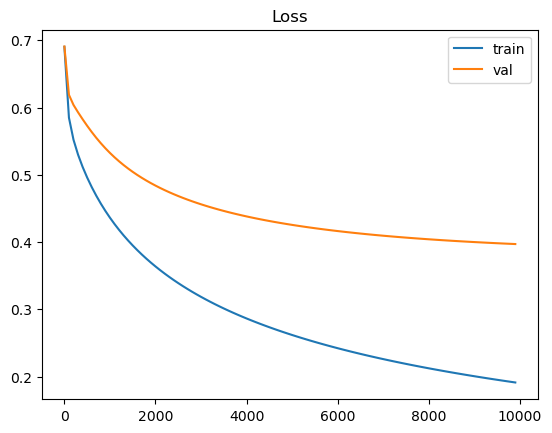

In [49]:
model.plot_loss()

Plotting the accuracy function on the training data and the test data for each epoch

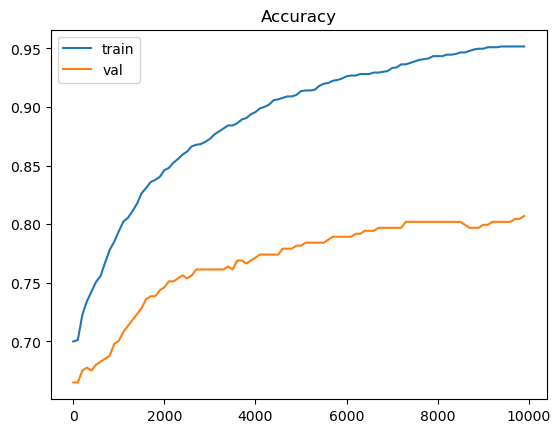

In [50]:
model.plot_accuracy()